In [1]:
%matplotlib inline

import os
import sys
import pickle

import yaml
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../')
from src.hawkes_object import NHGPS
from src.variational_inference import VI

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

### Define the parameters of the model

In [3]:
intensity_bound = 25
num_trials = 1
time_bound = 10
memory_decay = 1.5
effects_kernel_output_variance = 0.8
effects_kernel_length_scale = 0.5
background_kernel_output_variance = 0.5
backgroung_kernel_length_scale = 2.5
hypers = [effects_kernel_output_variance, effects_kernel_length_scale, memory_decay, \
          background_kernel_output_variance, backgroung_kernel_length_scale]

obj = NHGPS(intensity_bound, time_bound, hypers, num_trials)

### sample the GPs
you need JAX installed for this part, but it runs easily also without GPU

In [4]:
num_grid_samples = 1000
time_grid = np.linspace(0.000001, time_bound, num_grid_samples, dtype=np.float64)
time_grid = np.reshape(time_grid, [time_grid.shape[0], 1])
obj.generate_temporal_gp(time_grid)

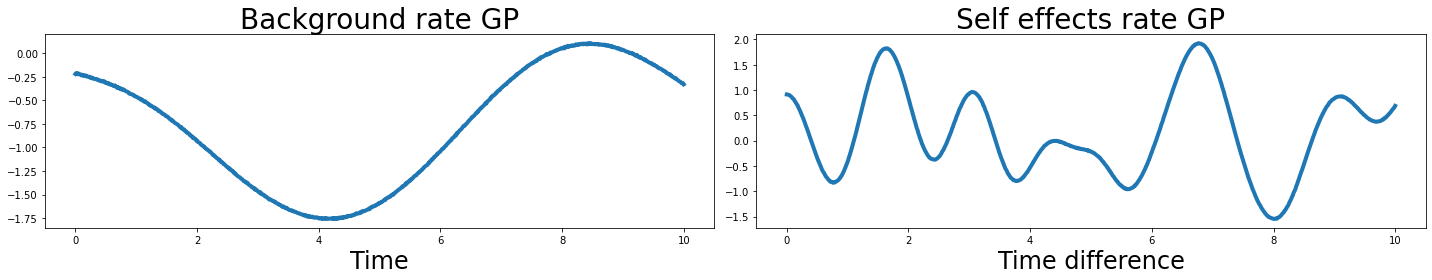

In [5]:
fig, axs = plt.subplots(1,2, figsize=(20,4))
axs[0].plot(time_grid, obj.temporal_gp_background_sample, linewidth=4)
axs[0].set_title('Background rate GP', fontsize=28)
axs[0].set_xlabel('Time', fontsize=24)

axs[1].plot(time_grid, obj.temporal_gp_sample, linewidth=4)
axs[1].set_title('Self effects rate GP', fontsize=28)
axs[1].set_xlabel('Time difference', fontsize=24)
plt.tight_layout()
plt.show()

### Generate events using thinning

In [11]:
# Generate candidates
expected_num_candidates = intensity_bound * time_bound
number_of_candidates = [np.random.poisson(expected_num_candidates) for n in range(num_trials)]
candidates = obj.generate_candidates(number_of_candidates, num_trials)

print(f'the number of candidates in each trial is: {number_of_candidates}')

the number of candidates in each trial is: [245]


In [13]:
# This may take a while.... 
obj.reset_intensities()
observations = obj.thinning(candidates)

0


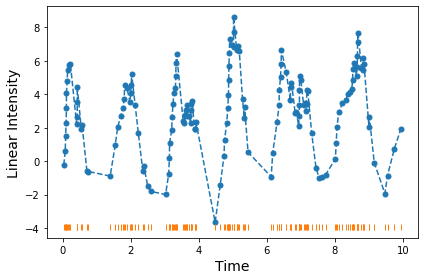

In [14]:
for t in range(obj.num_trials):
    plt.plot(observations[t], obj.phis[t], '--.', markersize=10, label=r'$\phi$')
    plt.plot(observations[t], np.repeat(np.min(obj.phis[t]) - 0.3, len(observations[t])), '|', label='accepted')
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Linear Intensity', fontsize=14)
    plt.tight_layout()
    plt.show()
phis_history = obj.phis

### Save the data for inference

In [15]:
file_name = 'dataset_7_1.p'
datasets_folder = '../data/synthetic_data'
file_path = os.path.join(datasets_folder, file_name)
with open(file_path, 'wb') as f:
    pickle.dump([observations, obj.phis, obj.temporal_gp_points, obj.temporal_gp_sample,
                obj.temporal_gp_background_points, obj.temporal_gp_background_sample], f)


In [10]:
import yaml
params_dict = {'data': file_path,
               'intensity_bound': intensity_bound, 'time_bound': time_bound,
               'lambda_a_prior': 2., 'lambda_b_prior': 0.03, 'fixed_lambda': False, 
               'effects_kernel_output_variance': effects_kernel_output_variance, 'effects_kernel_length_scale': effects_kernel_length_scale,
               'memory_decay': memory_decay, 'background_kernel_output_variance': background_kernel_output_variance,
               'backgroung_kernel_length_scale': backgroung_kernel_length_scale,
               'start_from_given': True, 'init_effects_kernel_output_variance': 1., 'init_effects_kernel_length_scale': 1.,
               'init_memory_decay': 5.1, 'init_backgroung_kernel_length_scale': 0.2, 'init_background_kernel_output_variance': 2.,
               'grad_step_size': 0.01,
               'use_history': True, 'sample_hyper': False, 'adapt_grad_step_size': False, 'hypers_iteration': 10,
               'save_steps': True, 'infer_max_intensity': True,
               'num_inducing_points': 100, 'num_integration_points': 500,
               'convergence_criteria': 0.0001, 'noise': 0.0001,
               'test_likelihood': False, 'estimate_s_g': True
              }

settings_file_name = 'settings_' + file_name[:-2] + '.yml'
settings_file_path = os.path.join(datasets_folder, settings_file_name)
with open(settings_file_path, 'w') as f:
    yaml.dump(params_dict, f)